# KMeans Clustering

In [1]:
%matplotlib inline

import datacube
# from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, create_cfmask_clean_mask
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, ls7_unpack_qa
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset

from datetime import datetime
import xarray as xr
import gdal
import numpy as np

# dc_api = DataAccessApi(config='/home/localuser/.datacube.conf')
dc = datacube.Datacube(config='/home/localuser/.datacube.conf', app='kmeans_clustering')
lat_range = (10.9, 11.00)
lon_range = (107.8, 107.9)
time_range = (datetime(2015,1,1), datetime(2017,1,1))

In [2]:
# product = "ls8_ledaps_vietnam"
product = "ls8_lasrc_vietnam"
platform = "LANDSAT_8"

In [3]:
# dc.get_datacube_metadata(platform=platform,product=product)
# print(dc.list_products().loc[dc.list_products()['name'] == product])

In [4]:
product_details = dc.list_products()[dc.list_products().name == product]

# acquisitions = dc.list_acquisition_dates("LANDSAT_8", product, time=time_range, 
#                                          longitude=lon_range, latitude=lat_range)

geographic_chunks = create_geographic_chunks(latitude=lat_range, longitude=lon_range, geographic_chunk_size=.05)

In [5]:
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']#, 'cf_mask']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
#     data = dc.get_dataset_by_extent(product, time=time_range, 
#                                     longitude=chunk['longitude'], latitude=chunk['latitude'], 
#                                     measurements=measurements)
    data = dc.load(product=product, time=time_range, 
                   lon=chunk['longitude'], lat=chunk['latitude'], 
                   measurements=measurements)

#     clean_mask = create_cfmask_clean_mask(data.cf_mask)
    clear_xarray  = ls7_unpack_qa(data.pixel_qa, "clear")
    water_xarray  = ls7_unpack_qa(data.pixel_qa, "water")
    clean_mask = np.logical_or(clear_xarray.values.astype(bool),
                               water_xarray.values.astype(bool))
    product_chunks.append(create_median_mosaic(data))#, clean_mask=np.ones(clean_mask.shape).astype(np.bool)))#clean_mask))

final_mosaic = combine_geographic_chunks(product_chunks)

write_geotiff_from_xr("ls8_median_mosaic.tif", final_mosaic, measurements, nodata=-9999)

In [6]:
final_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
Data variables:
    blue       (latitude, longitude) int32 229 224 209 185 210 231 247 250 ...
    green      (latitude, longitude) int32 441 457 420 406 452 486 518 506 ...
    red        (latitude, longitude) int32 274 273 276 256 302 358 395 416 ...
    nir        (latitude, longitude) int32 3429 3223 3054 2896 3263 3702 ...
    swir1      (latitude, longitude) int32 1538 1577 1495 1348 1537 1735 ...
    swir2      (latitude, longitude) int32 621 644 586 547 643 772 823 888 ...
    pixel_qa   (latitude, longitude) int32 322 322 322 322 322 322 322 322 ...

In [7]:
classification_4 = kmeans_cluster_dataset(final_mosaic, n_clusters=4)
classification_8 = kmeans_cluster_dataset(final_mosaic, n_clusters=8)
classification_12 = kmeans_cluster_dataset(final_mosaic, n_clusters=12)

write_geotiff_from_xr("ls8_cluster4.tif", classification_4, ['classification'], nodata=-9999)
write_geotiff_from_xr("ls8_cluster8.tif", classification_8, ['classification'], nodata=-9999)
write_geotiff_from_xr("ls8_cluster12.tif", classification_12, ['classification'], nodata=-9999)

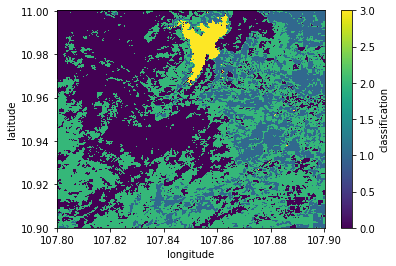

In [8]:
classification_4.classification.plot()

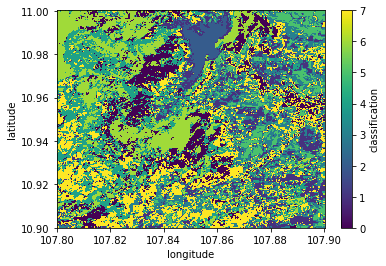

In [9]:
classification_8.classification.plot()

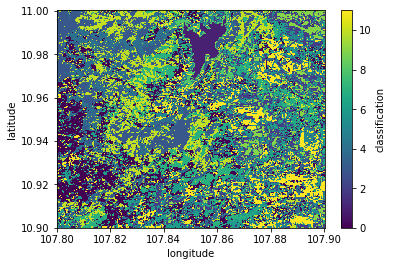

In [10]:
classification_12.classification.plot()